# Advanced Examples of Sequence Space Jacobians in HARK

This notebook has additional examples of the kinds of things you can do with HARK's sequence space Jacobian (SSJ) constructor functionality. If you don't know anything at all about that, we recommend you read the SSJ tutorial notebook first, or even the notebook that explains what an SSJ is.

In [1]:
# First, let's import some basic things and define a plotting function
from time import time
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs
import numpy as np


# Define a simple function for plotting SSJs
def plot_SSJ(jac, S, outcome, shock):
    if type(S) is int:
        S = [S]
    for s in S:
        plt.plot(jac[:, s], "-", label="s=" + str(s))
    plt.legend()
    plt.xlabel(r"time $t$")
    plt.ylabel("rate of change of " + outcome)
    plt.title("SSJ for " + outcome + " with respect to " + shock + r" at time $s$")
    plt.tight_layout()
    plt.xlim(-1, jac.shape[0] + 1)
    plt.show()

## Using Alternative Constructors

Each `AgentType` subclass is specified to work "off the shelf", with default constructors that build complex model objects (like the distribution of income shocks) from primitive parameters. But what if you want to make (e.g.) different distributional assumptions, or build in additional capabilities? In this example, we walk you through how to do that.

Suppose you're interested in the `IndShockConsumerType` model, but the macroeconomic framework in which your consumers will live has variable wage rates. The wage rate doesn't appear in the `ConsIndShock` model, and the default constructor for `IncShkDstn` doesn't have a wage rate either. However, HARK already has a small extension of the `IncShkDstn` constructor, which *does* have a wage rate built in. Let's make an instance of `IndShockConsumerType` that uses that alternative constructor, then construct SSJs for it.

In [2]:
# Import our AgentType subclass and alternative constructor
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    IndShockConsumerType_constructors_default,
)
from HARK.Calibration.Income.IncomeProcesses import (
    construct_HANK_lognormal_income_process_unemployment,
)

# Substitute the new constructor into the base constructor dictionary
my_constructors = IndShockConsumerType_constructors_default.copy()
my_constructors["IncShkDstn"] = construct_HANK_lognormal_income_process_unemployment

# Make a parameter dictionary with the new / updated parameters for that constructor
some_new_params = {
    "tax_rate": [0.0],
    "labor": [1.0],
    "wage": [1.0],
    "constructors": my_constructors,
}

# Make an AgentType instance with our alternative constructor
IndShkTypeWithWage = IndShockConsumerType(cycles=0, **some_new_params)

In [3]:
# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401}
consumption_grid_spec = {"min": 0.0, "max": 5.0, "N": 151}
my_basic_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec}

# Make SSJs for asset holdings and consumption with respect to interest factor and wage rate
t0 = time()
SSJ_K_r, SSJ_C_r = IndShkTypeWithWage.make_basic_SSJ(
    "Rfree", ["aNrm", "cNrm"], my_basic_grid_specs, norm="PermShk"
)
SSJ_K_w, SSJ_C_w = IndShkTypeWithWage.make_basic_SSJ(
    "wage", ["aNrm", "cNrm"], my_basic_grid_specs, norm="PermShk"
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds.")

Constructing those SSJs took 18.420 seconds.


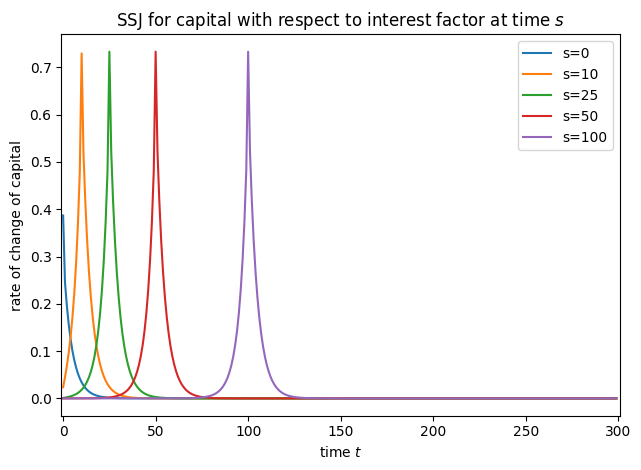

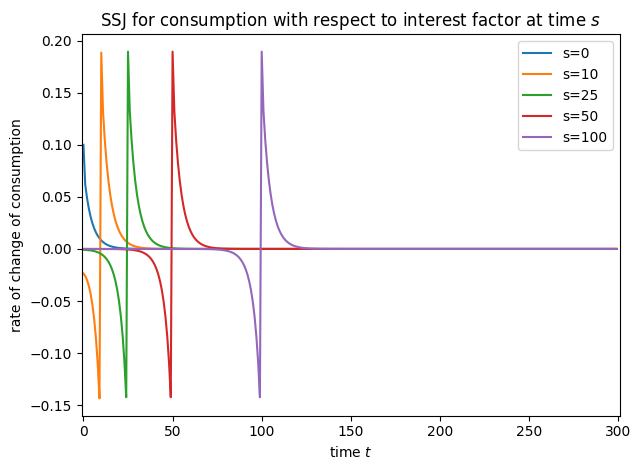

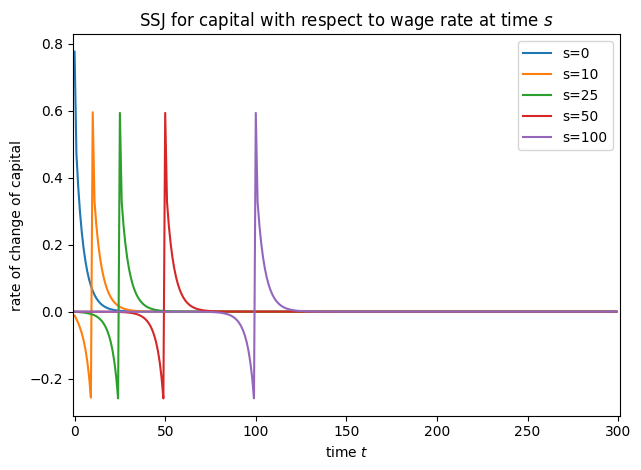

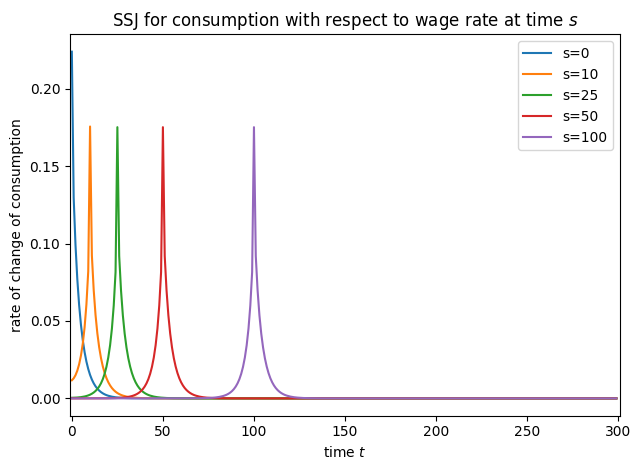

In [4]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "capital", "interest factor")
plot_SSJ(SSJ_C_r, [0, 10, 25, 50, 100], "consumption", "interest factor")
plot_SSJ(SSJ_K_w, [0, 10, 25, 50, 100], "capital", "wage rate")
plot_SSJ(SSJ_C_w, [0, 10, 25, 50, 100], "consumption", "wage rate")

In fact, the `NewKeynesianConsumerType` is simply a variation of `IndShockConsumerType` with this income process substituted in, and *handwritten* methods for computing SSJs for *only* assets and consumption. HARK's new SSJ constructor method should work for (almost) *all* `AgentType` subclasses, and for any simulation output.

## Adding Labor Supply on the Intensive Margin

Now suppose you want to work with a *properly* new Keynesian macroeconomic environment, so that agents can vary the intensity of their labor supply depending on the wage rate (and their personal circumstances). The `LaborIntMargConsumerType` does just that, so let's work with it.

In [5]:
# Import and create an agent who chooses labor on the intensive margin
from HARK.ConsumptionSaving.ConsLaborModel import LaborIntMargConsumerType

LaborSupplyType = LaborIntMargConsumerType(cycles=0)
# This will raise some harmless warnings

# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401}
labor_grid_spec = {"min": 0.0, "max": 2.0, "N": 201}
my_labor_grid_specs = {"kNrm": assets_grid_spec, "LbrEff": labor_grid_spec}

C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsLaborModel.py:144: RuntimeWarning: divide by zero encountered in divide
  * (bNrmGridTerm / (WageRte_T * TranShkGridTerm) + 1.0),
C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsLaborModel.py:144: RuntimeWarning: invalid value encountered in divide
  * (bNrmGridTerm / (WageRte_T * TranShkGridTerm) + 1.0),
C:\Users\Matthew\Documents\GitHub\HARK\HARK\rewards.py:66: RuntimeWarning: divide by zero encountered in power
  return c**-rho


In [6]:
# Construct SSJs for capital and labor with respect to the interest factor and the wage rate
t0 = time()
SSJ_K_r, SSJ_L_r = LaborSupplyType.make_basic_SSJ(
    "Rfree", ["aNrm", "LbrEff"], my_labor_grid_specs, norm="PermShk"
)
t1 = time()
print(
    "Constructing the SSJs with respect to the interest factor took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

t0 = time()
SSJ_K_w, SSJ_L_w = LaborSupplyType.make_basic_SSJ(
    "WageRte", ["aNrm", "LbrEff"], my_labor_grid_specs, norm="PermShk", solved=True
)
t1 = time()
print(
    "Constructing the SSJs with respect to the wage rate took {:.3f}".format(t1 - t0)
    + " seconds."
)

Constructing the SSJs with respect to the interest factor took 43.873 seconds.
Constructing the SSJs with respect to the wage rate took 41.364 seconds.


Notice that the second time `make_basic_SSJ` is called, the argument `solved=True` is also passed. This is because the long run model is the same no matter what, so once it has been solved once (in the first call), we don't need to re-solve it.

This model is a little less standard than the `IndShockConsumerType`, so let's plot the policy functions so we're familiar with what's going on. Conveniently, `LaborIntMargConsumerType` has a couple of methods for quickly plotting its policy functions. The state variables at decision-time are bank balances $b_t$ and the transitory productivity shock $\theta_t$. The figures below plot the consumption function by $b_t$ at various levels of transitory productivity.

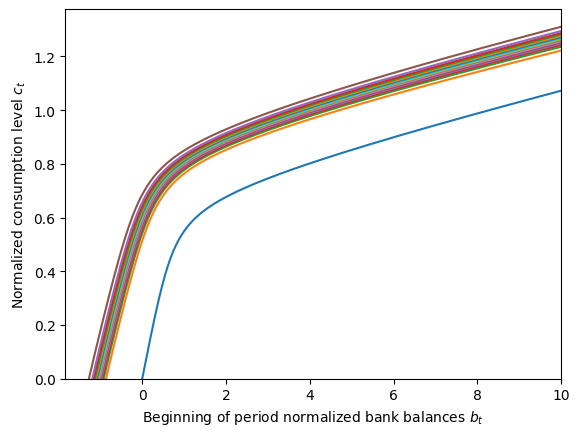

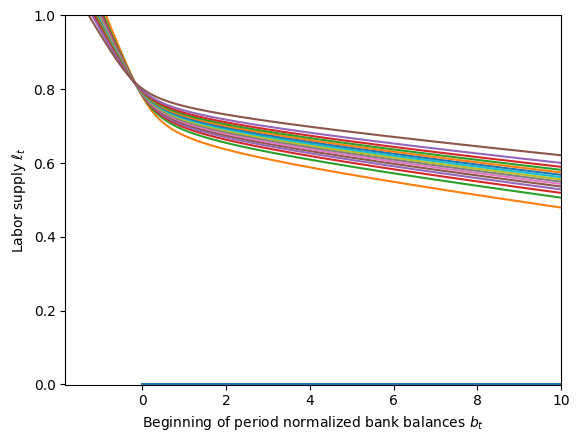

In [7]:
LaborSupplyType.plot_cFunc(0, bMax=10.0)
LaborSupplyType.plot_LbrFunc(0, bMax=10.0)

The blue curve that sits below all the others is for $\theta_t=0$, representing unemployment at zero productivity; note the barely visible "zero labor supplied" curve in the second figure. The first figure might lead you to believe that this agent can borrow against future earnings, because their consumption function is defined for some $b_t < 0$ when $\theta_t > 0$, but this isn't really the case. Note that for every level of $\theta$, the consumption function goes to zero at exactly the same $b_t$ as where the labor function goes to 1 (zero leisure). That minimum $b_t$ represents the beginning-of-period wealth they need to have so that if they work 100% of the time *and* consume nothing, they will end the period with $a_t=0$. Why is that important? Because productivity shocks are iid, and they *might* get $\theta_{t+1}=0$; knowing that they need to be in a legal state in $t+1$, the agent will *never* end their period with less than $a_t = 0$ and risk having no resources next period while unemployed.

Also note that at levels of $b_t$ that the agent will actually visit, labor supply is *increasing* in transitory productivity $\theta_t$: the agent will work more when it's a "good time to work". Labor supply is also *decreasing* in $b_t$. When the agent has more cash on hand already, they want to consume more *and* don't need to work as much to finance that consumption. Note that a consequence of this is that a large *permanent* productivity shock $\psi_t > 1$ will decrease *normalized* bank balances $b_t$ and thus induce the agent to supply more labor-- again, they will work more when it's a "good time to work".

We provide all of that as prelude to plotting the SSJs, to aid in your interpretation of aggregate responses.

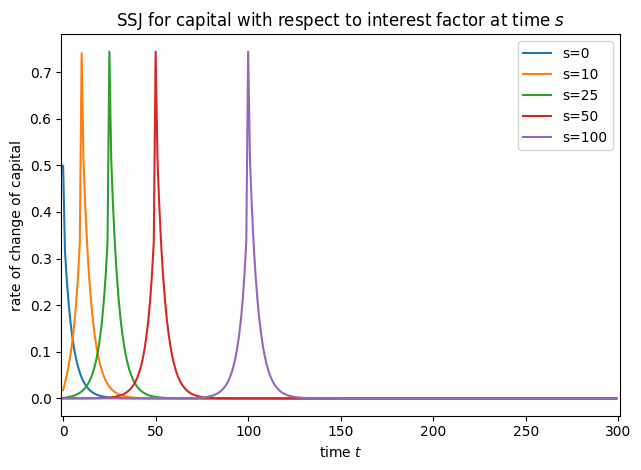

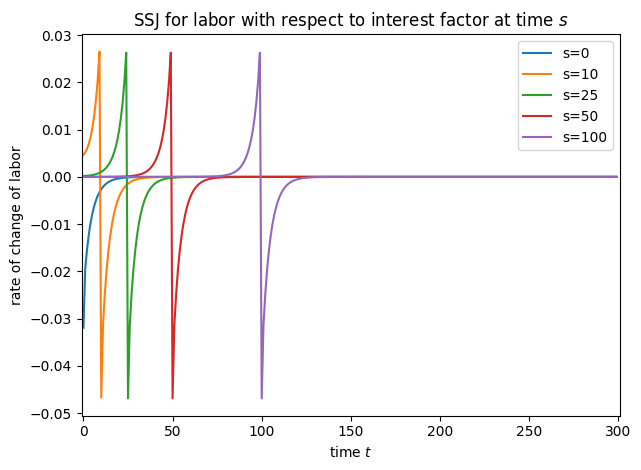

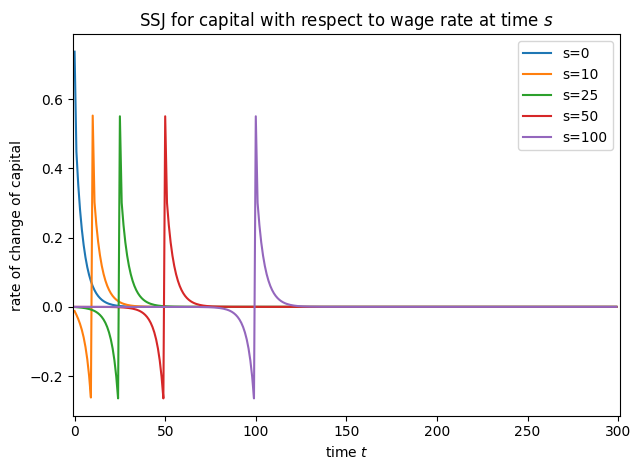

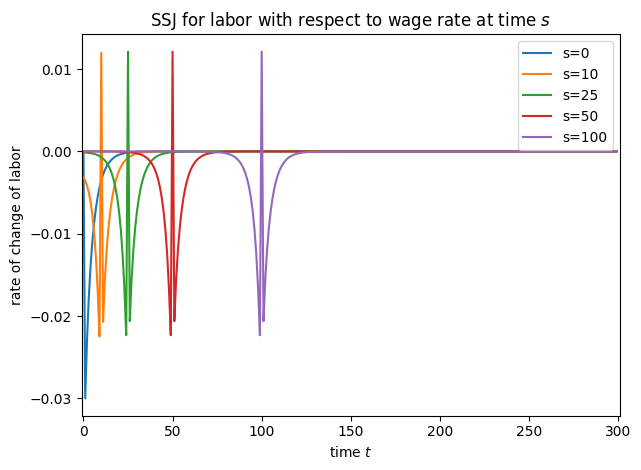

In [8]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "capital", "interest factor")
plot_SSJ(SSJ_L_r, [0, 10, 25, 50, 100], "labor", "interest factor")
plot_SSJ(SSJ_K_w, [0, 10, 25, 50, 100], "capital", "wage rate")
plot_SSJ(SSJ_L_w, [0, 10, 25, 50, 100], "labor", "wage rate")

## Implementing Unemployment Dynamics

Now suppose you're interested in a model in which agents can be *persistently* unemployed, transitioning between employment and unemployment with known probabilities. In your macroeconomic environment, these transition probabilities might be determined endogenously, but from the perspective of one individual agent, they treat them as given.

HARK can handle this kind of model using its `MarkovConsumerType`, which adds a discrete state on top of the `IndShockConsumerType` model. Several model objects can depend on the discrete state: survival probabilities, the income shock distribution, the interest factor, and expected permanent income growth. Let's make an instance of `MarkovConsumerType` with two discrete states, one for unemployment (zero labor income) and the other for employment, that are otherwise identical. Conveniently, the default constructor for `MrkvArray` (the transition probabilities) is `make_simple_binary_markov`, so we don't have to change much.

Let's say that discrete state `z=0` means unemployment and state `z=1` means employment. The default `IncShkDstn` constructor for `MarkovConsumerType` is called `construct_markov_lognormal_income_process_unemployment`; it expects to get inputs for `PermShkStd`, `TranShkStd`, `UnempPrb`, and `IncUnemp` as they vary by discrete state `z`. We also need to make sure the discrete states don't vary in any other way, and to set the persistence of (un)employment in the long run.

Because we might be interested in how interest rates affect aggregate outcomes, `Rfree` will be a `shock` parameter. Note that *only* real-valued parameters (or those in a singleton list) are eligible to be a `shock`, but `Rfree` is a list of *arrays* of interest factors by discrete state. There's an easy fix for this: add a trivial constructor function for `Rfree`

In [9]:
# Import our agent type
import numpy as np
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distributions import DiscreteDistributionLabeled

# Specify parameters that differ from defaults
my_markov_params = {
    "PermShkStd": np.array([[0.1, 0.1]]),
    "TranShkStd": np.array([[0.1, 0.1]]),
    "UnempPrb": np.array([0.9999, 0.0]),
    "IncUnemp": np.array([0.0, 0.0]),
    "Mrkv_p11": [0.75],  # expect to be unemployed for 4 periods
    "Mrkv_p22": [0.985],  # expect to be employed for 67 periods
    "MrkvPrbsInit": np.array([0.1, 0.9]),
    "PermGroFac": [np.array([1.01, 1.01])],
    "LivPrb": [np.array([1.0, 1.0])],
    "Rfree_all": [1.03],  # a new parameter that we'll use to make Rfree!
    "DiscFac": 0.96,
    "tolerance": 1e-12,
}

# Define a substitute "unemployed" income distribution because the default constructor doesn't like zero income
UnemployedIncDstn = DiscreteDistributionLabeled(
    pmv=np.array([1.0]),
    atoms=np.array([[1.0], [0.0]]),
    var_names=["PermShk", "TranShk"],
)

In [10]:
# Define a trivial constructor function for Rfree
def make_flat_Rfree(T_cycle, MrkvArray, Rfree_all):
    K = MrkvArray[0].shape[0]
    Rfree = T_cycle * [Rfree_all * np.ones(K)]
    return Rfree

In [11]:
# Make and solve an infinite horizon problem with persistent unemployment
UnempDynType = MarkovConsumerType(cycles=0, **my_markov_params)
UnempDynType.IncShkDstn[0][0] = UnemployedIncDstn
UnempDynType.constructors["Rfree"] = make_flat_Rfree
UnempDynType.update()
UnempDynType.solve()

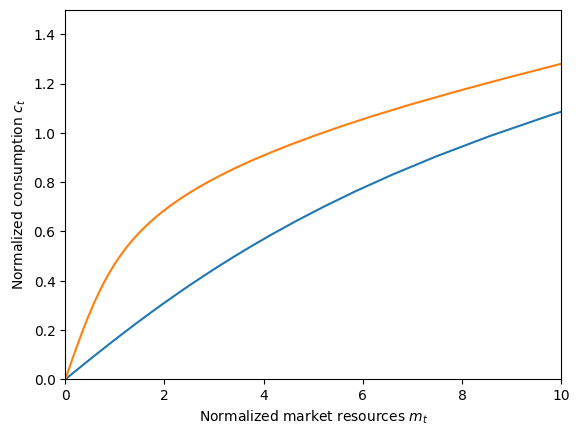

In [12]:
# Plot the state-dependent consumption functions
UnempDynType.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 1.5)
plot_funcs(UnempDynType.cFunc[0], 0.0, 10.0)

The orange plot is the consumption function when employed, and the blue plot is the consumption function when unemployed. For those familiar with Chris Carroll's "tractable buffer stock" model, you might notice that the unemployed consumption function here looks a bit like the "unemployed" consumption function for the TBS model. This is sensible: being persistently unemployed with only a 25% chance of recovery each period is *qualitatively related to* knowing that you will never, ever receive labor income again.

Before proceeding to constructing the SSJs, let's take a look at what the long run distribution of (arrival) states is for this model. The distribution we're about to plot is actually constructed in the background as part of the process of making SSJs via the "fake news" algorithm, but hidden from the user. Let's take a quick look at what's happening "under the hood".

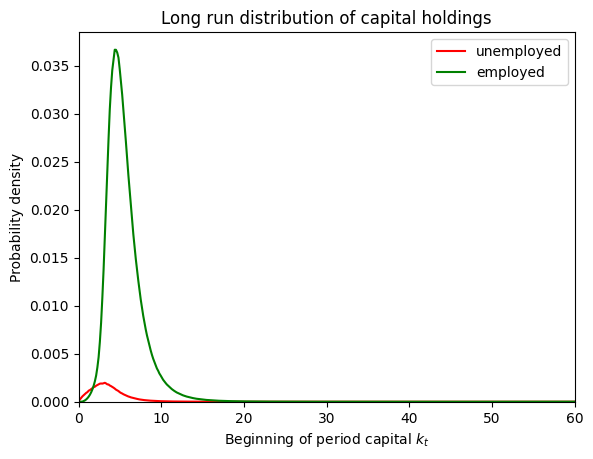

In [13]:
# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 60.0, "N": 401}
consumption_grid_spec = {"min": 0.0, "max": 3.0, "N": 201}
z_grid = {"N": 2}
my_mrkv_grid_specs = {
    "kNrm": assets_grid_spec,
    "cNrm": consumption_grid_spec,
    "zPrev": z_grid,
}

# Find the steady state distribution and unpack it
UnempDynType.initialize_sym()
UnempDynType._simulator.make_transition_matrices(my_mrkv_grid_specs, norm="PermShk")
UnempDynType._simulator.find_steady_state()
kNrm_grid = UnempDynType._simulator.periods[0].grids["kNrm"]
SS_dstn = np.reshape(UnempDynType._simulator.steady_state_dstn, (401, 2))

# Plot the steady state distribution of capital
plt.plot(kNrm_grid, SS_dstn[:, 0], "-r", label="unemployed")
plt.plot(kNrm_grid, SS_dstn[:, 1], "-g", label="employed")
plt.xlabel(r"Beginning of period capital $k_t$")
plt.ylabel("Probability density")
plt.title("Long run distribution of capital holdings")
plt.legend()
plt.ylim(0.0, None)
plt.xlim(0.0, 60.0)
plt.show()

The SSJ constructor builds a representation of the model for simulation purposes (holding it in the `_simulator` attribute of the `AgentType` instance) and makes discretized transition matrices. The `steady_state_dstn` has size 802, or 401 capital gridpoints times 2 discrete states; the distribution is stored as a 1D vector but can be reshaped back into its "natural" form.

The grids that are built can also be used to calculate long run distributions of other outcomes. Let's do a quick calculation of the steady state (un)employment rate in our specification.

In [14]:
# Find the distributional mapping from arrival states to the discrete employment state
z_outcomes = UnempDynType._simulator.periods[0].matrices["z"]

# Combine the steady state distribution with that mapping
emp_dstn_LR = np.dot(SS_dstn.flatten(), z_outcomes)
print("The long run unemployed rate is {:.1f}".format(100 * emp_dstn_LR[0]) + "%.")
print("The long run employed rate is {:.1f}".format(100 * emp_dstn_LR[1]) + "%.")

The long run unemployed rate is 5.7%.
The long run employed rate is 94.3%.


If you do a hand calculation of the steady state (un)employment rate based on the dynamics we chose, you'll get the same result!

Now we can make SSJs with respect to the interest factor and the persistence of (un)employment. Notice that the `shock` parameter for the interest rate is `Rfree_all`, the new parameter we defined above for use in the simple constructor function. When `Rfree_all` is perturbed, the change is applied through `make_flat_Rfree` to both discrete states. Likewise, we name the SSJ for (un)employment persistence `UU` or `EE` to be a bit more descriptive about what `Mrkv_p11` and `Mrkv_p22` mean in this context.

In [15]:
# Calculate SSJs with respect to the interest factor and (un)employment flows
t0 = time()
SSJ_K_r, SSJ_C_r = UnempDynType.make_basic_SSJ(
    "Rfree_all", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True
)
t1 = time()
print(
    "Constructing the SSJs with respect to the interest factor took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

t0 = time()
SSJ_K_UU, SSJ_C_UU = UnempDynType.make_basic_SSJ(
    "Mrkv_p11", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True
)
t1 = time()
print(
    "Constructing the SSJs with respect to unemployment persistence took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

t0 = time()
SSJ_K_EE, SSJ_C_EE = UnempDynType.make_basic_SSJ(
    "Mrkv_p22", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True
)
t1 = time()
print(
    "Constructing the SSJs with respect to employment persistence took {:.3f}".format(
        t1 - t0
    )
    + " seconds in total."
)

Constructing the SSJs with respect to the interest factor took 35.616 seconds.
Constructing the SSJs with respect to unemployment persistence took 35.619 seconds.
Constructing the SSJs with respect to employment persistence took 35.497 seconds in total.


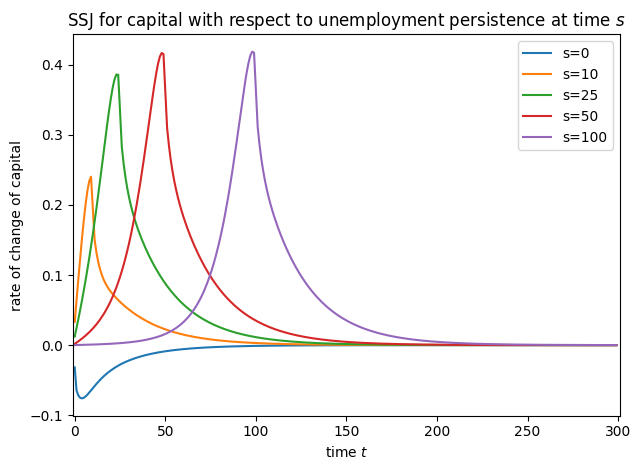

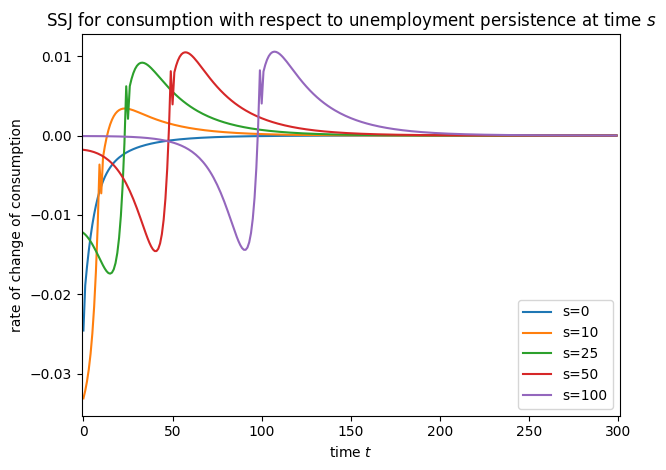

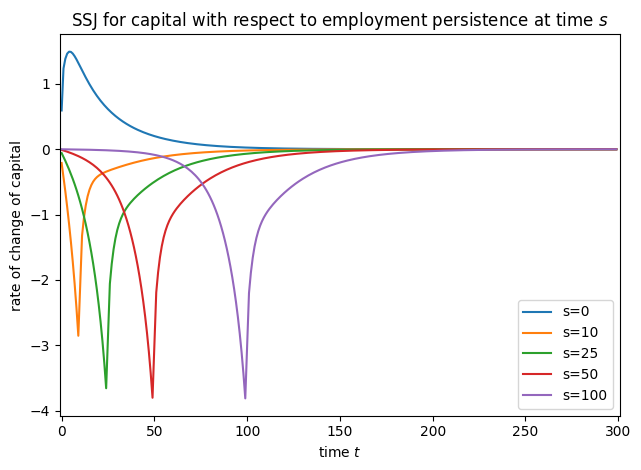

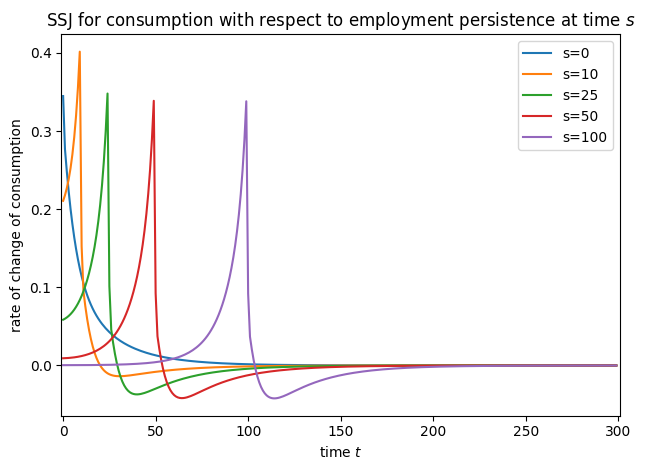

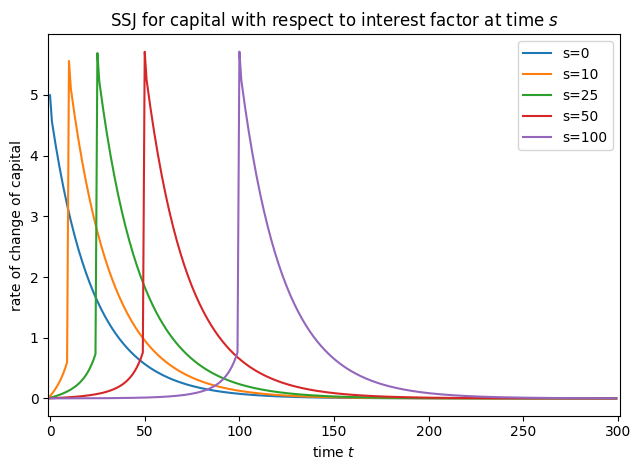

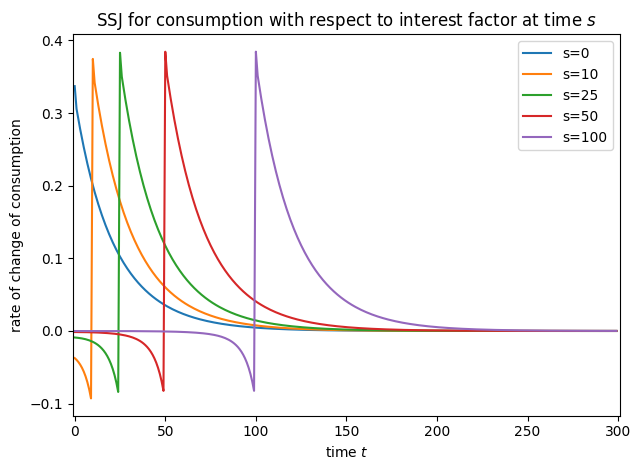

In [16]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_UU, [0, 10, 25, 50, 100], "capital", "unemployment persistence")
plot_SSJ(SSJ_C_UU, [0, 10, 25, 50, 100], "consumption", "unemployment persistence")
plot_SSJ(SSJ_K_EE, [0, 10, 25, 50, 100], "capital", "employment persistence")
plot_SSJ(SSJ_C_EE, [0, 10, 25, 50, 100], "consumption", "employment persistence")
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "capital", "interest factor")
plot_SSJ(SSJ_C_r, [0, 10, 25, 50, 100], "consumption", "interest factor")

## SSJs with Portfolio Choice

That was a lot of examples involving labor and employment, so let's pivot to something on the capital side and consider a model with portfolio choice. Maybe you might be interested in a model in which agents can store their wealth in a low (or no) interest bond, or invest in risky assets-- and only the risky asset is used to finance capital. HARK has a few models with portfolio allocation, but let's use the simplest one, `RiskyAssetConsumerType`. Start by importing the `AgentType` subclass and setting a few baseline parameters, then solve an infinite horizon problem.

In [18]:
# Import our AgentType and then choose some parameters
from HARK.ConsumptionSaving.ConsRiskyAssetModel import RiskyAssetConsumerType

my_risky_params = {
    "PortfolioBool": True,
    "Rfree": [1.0],
    "RiskyAvg": 1.03,
    "RiskyStd": 0.26,
    "RiskyCount": 7,
    "LivPrb": [1.0],
    "CRRA": 3.5,
    "aXtraMax": 50.0,
    "aXtraCount": 200,
    "aXtraNestFac": 1,
    "tolerance": 1e-10,
}

# Make and solve our portfolio choice model
PortChoiceType = RiskyAssetConsumerType(cycles=0, **my_risky_params)
t0 = time()
PortChoiceType.solve()
t1 = time()
print(
    "Solving the portfolio allocation model took {:.3f}".format(t1 - t0) + " seconds."
)

Solving the portfolio allocation model took 36.009 seconds.


Let's make sure the solution to the model looks sensible by plotting the policy functions.

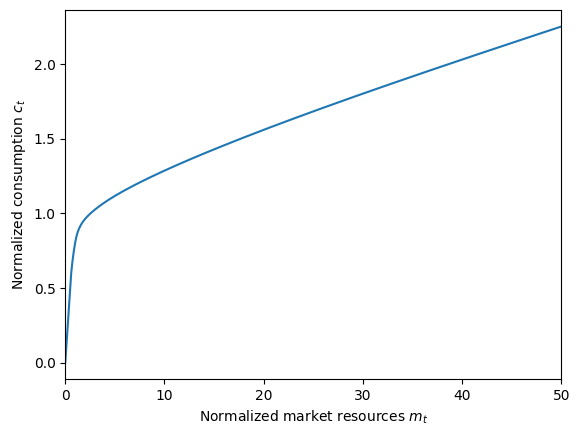

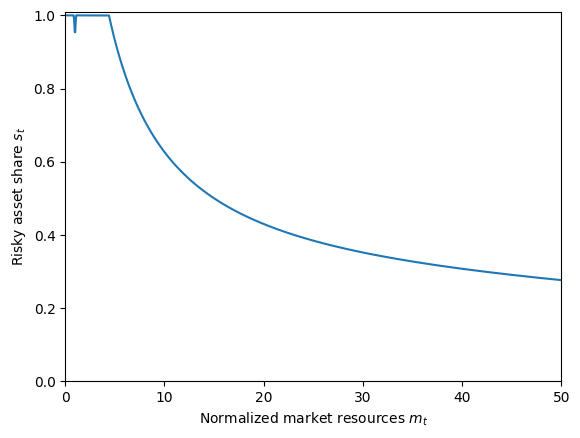

In [19]:
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(PortChoiceType.solution[0].cFunc, 0.0, 50.0)

plt.ylim(0.0, 1.01)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Risky asset share $s_t$")
plot_funcs(PortChoiceType.solution[0].ShareFunc, 0.0, 50.0)

That looks ok to me. Now we can define grids for our outcomes of interest, then compute SSJs.

In [20]:
assets_grid_spec = {"min": 0.0, "max": 60.0, "N": 301}
consumption_grid_spec = {"min": 0.0, "max": 2.0, "N": 201}
share_grid_spec = {"min": 0.0, "max": 1.0, "N": 101}
my_portfolio_grid_specs = {
    "kNrm": assets_grid_spec,
    "cNrm": consumption_grid_spec,
    "Share": share_grid_spec,
    "qNrm": assets_grid_spec,
}

t0 = time()
SSJ_K_r, SSJ_Q_r, SSJ_C_r = PortChoiceType.make_basic_SSJ(
    "RiskyAvg",
    ["aNrm", "qNrm", "cNrm"],
    my_portfolio_grid_specs,
    norm="PermShk",
    T_max=300,
    solved=True,
)
t1 = time()
print(
    "Constructing the SSJs with respect to mean risky return took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

t0 = time()
SSJ_K_s, SSJ_Q_s, SSJ_C_s = PortChoiceType.make_basic_SSJ(
    "RiskyStd",
    ["aNrm", "qNrm", "cNrm"],
    my_portfolio_grid_specs,
    norm="PermShk",
    T_max=300,
    solved=True,
)
t1 = time()
print(
    "Constructing the SSJs with respect to stdev risky return took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

t0 = time()
SSJ_K_f, SSJ_Q_f, SSJ_C_f = PortChoiceType.make_basic_SSJ(
    "Rfree",
    ["aNrm", "qNrm", "cNrm"],
    my_portfolio_grid_specs,
    norm="PermShk",
    T_max=300,
    solved=True,
)
t1 = time()
print(
    "Constructing the SSJs with respect to risk-free return return took {:.3f}".format(
        t1 - t0
    )
    + " seconds."
)

Constructing the SSJs with respect to mean risky return took 49.419 seconds.
Constructing the SSJs with respect to stdev risky return took 49.300 seconds.
Constructing the SSJs with respect to risk-free return return took 49.180 seconds.


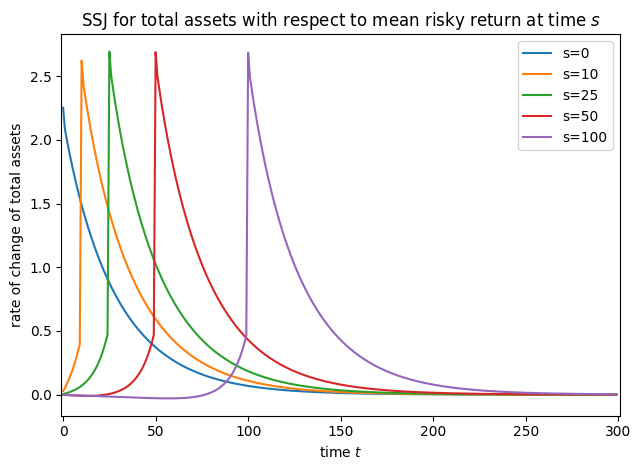

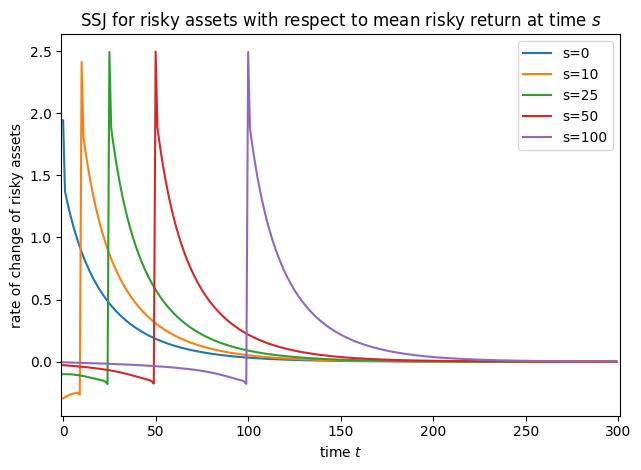

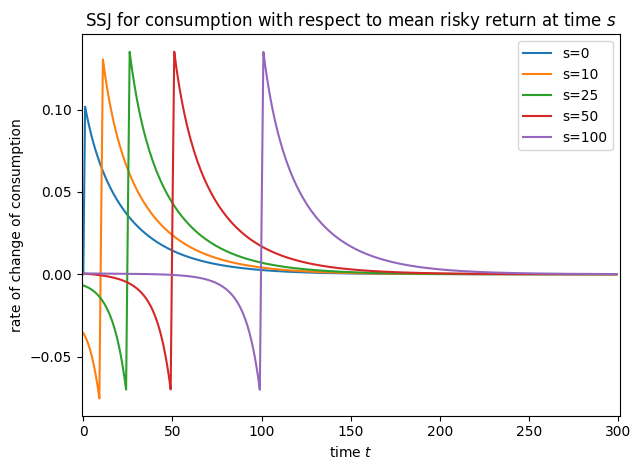

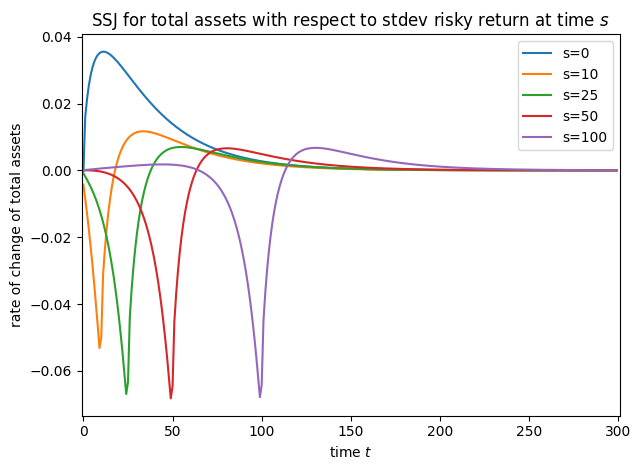

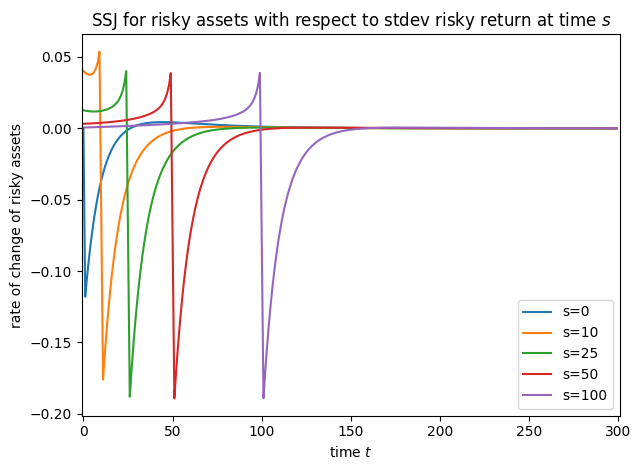

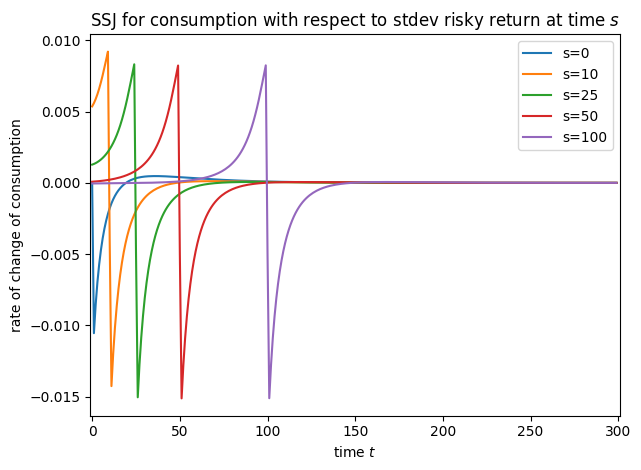

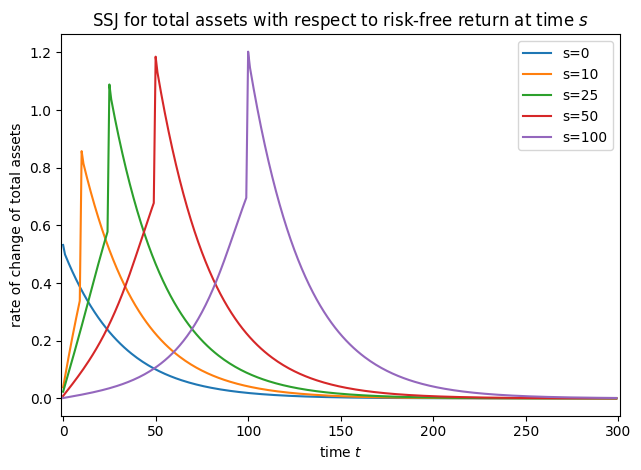

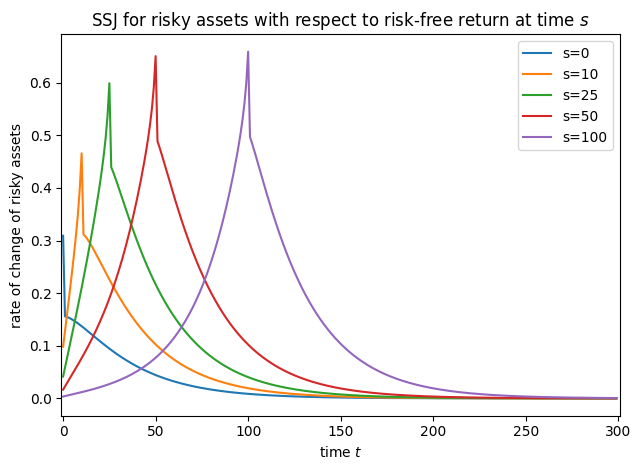

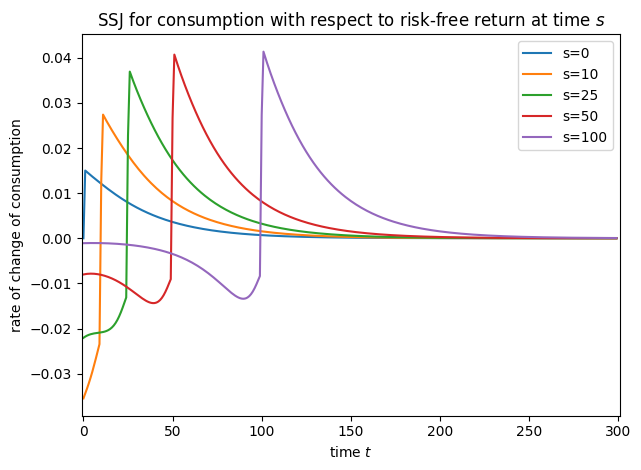

In [21]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "total assets", "mean risky return")
plot_SSJ(SSJ_Q_r, [0, 10, 25, 50, 100], "risky assets", "mean risky return")
plot_SSJ(SSJ_C_r, [0, 10, 25, 50, 100], "consumption", "mean risky return")
plot_SSJ(SSJ_K_s, [0, 10, 25, 50, 100], "total assets", "stdev risky return")
plot_SSJ(SSJ_Q_s, [0, 10, 25, 50, 100], "risky assets", "stdev risky return")
plot_SSJ(SSJ_C_s, [0, 10, 25, 50, 100], "consumption", "stdev risky return")
plot_SSJ(SSJ_K_f, [0, 10, 25, 50, 100], "total assets", "risk-free return")
plot_SSJ(SSJ_Q_f, [0, 10, 25, 50, 100], "risky assets", "risk-free return")
plot_SSJ(SSJ_C_f, [0, 10, 25, 50, 100], "consumption", "risk-free return")

These might look a little funky to me and I need to diagnose what's going on.